In [2]:
%load_ext autoreload
%autoreload 2
from functions import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display
from sklearn import metrics


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#Breast Cancer
df_raw = connect(r"""with Breast AS
(SELECT TOP (1500) [NoteID],[TEXT],CASE 
                  WHEN [TEXT] IS NOT NULL THEN (1) END AS CAT    
                  FROM [mimiciii].[dbo].[NOTEEVENTS] where 
                  CONTAINS([TEXT],'NEAR((CARCINOMA,BREAST),2,TRUE)') OR
                  CONTAINS([TEXT],'NEAR((TRIPLE,NEGATIVE),1,TRUE)') OR 
                  CONTAINS([TEXT],'NEAR((METASTATIC,BREAST),3,TRUE)') OR 
                  CONTAINS([TEXT],'NEAR((BREAST,CANCER),1,TRUE)') AND NOT(
                  CONTAINS([TEXT],'NEAR((DIABETES,MELLITUS),1,TRUE)')) AND NOT(
                  CONTAINS([TEXT],'NEAR((LUNG,CANCER),4,TRUE)')) order by [NoteID] ASC
),NonBC AS
(SELECT TOP (1500) [NoteID],[TEXT],CASE 
                  WHEN [TEXT] IS NOT NULL THEN (0) END AS CAT    
                  FROM [mimiciii].[dbo].[NOTEEVENTS] where 
                  NOT(CONTAINS([TEXT],'NEAR((CARCINOMA,BREAST),2,TRUE)')) OR
                  NOT (CONTAINS([TEXT],'NEAR((TRIPLE,NEGATIVE),1,TRUE)')) OR 
                  NOT(CONTAINS([TEXT],'NEAR((METASTATIC,BREAST),3,TRUE)'))OR 
                  NOT (CONTAINS([TEXT],'NEAR((BREAST,CANCER),1,TRUE)')) order by [NoteID] ASC
)
select * from Breast
UNION
SELECT * FROM NonBC""",params =None)

In [4]:
#Breast Cancer
df_test = connect(r"""with Breast AS
(SELECT TOP (500) [NoteID],[TEXT],CASE 
                  WHEN [TEXT] IS NOT NULL THEN (1) END AS CAT    
                  FROM [mimiciii].[dbo].[NOTEEVENTS] where 
                  CONTAINS([TEXT],'NEAR((CARCINOMA,BREAST),2,TRUE)') OR
                  CONTAINS([TEXT],'NEAR((TRIPLE,NEGATIVE),1,TRUE)') OR 
                  CONTAINS([TEXT],'NEAR((METASTATIC,BREAST),3,TRUE)') OR 
                  CONTAINS([TEXT],'NEAR((BREAST,CANCER),1,TRUE)') AND NOT(
                  CONTAINS([TEXT],'NEAR((DIABETES,MELLITUS),1,TRUE)')) AND NOT(
                  CONTAINS([TEXT],'NEAR((LUNG,CANCER),4,TRUE)')) order by [NoteID] DESC
),NonBC AS
(SELECT TOP (500) [NoteID],[TEXT],CASE 
                  WHEN [TEXT] IS NOT NULL THEN (0) END AS CAT    
                  FROM [mimiciii].[dbo].[NOTEEVENTS] where 
                  NOT(CONTAINS([TEXT],'NEAR((CARCINOMA,BREAST),2,TRUE)')) OR
                  NOT (CONTAINS([TEXT],'NEAR((TRIPLE,NEGATIVE),1,TRUE)')) OR 
                  NOT(CONTAINS([TEXT],'NEAR((METASTATIC,BREAST),3,TRUE)'))OR 
                  NOT (CONTAINS([TEXT],'NEAR((BREAST,CANCER),1,TRUE)')) order by [NoteID] DESC
)
select * from Breast
UNION
SELECT * FROM NonBC""",params =None)

In [5]:
df_raw = df_raw.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)

In [6]:
df_raw.head()

,NoteID,TEXT,CAT
0,26157,Admission Date: [**2150-8-4**] D...,1
1,876,"Pt is a 67 yo white female, biba s/p ped struc...",0
2,1312,Demographics\n Ideal body weight: 72.6 None\...,0
3,15,TITLE: This is a 74 year-old woman with a PMH ...,0
4,139,Admission Date: [**2112-7-2**] Discharg...,0


In [7]:
IDTr, DocTypeTr, NotesTr= Dataframe(df_raw )
IDTs, DocTypeTs, NotesTs= Dataframe(df_test)
NormTrain= normalize_corpus(NotesTr,tokenize=False)
NormTest= normalize_corpus(NotesTs,tokenize=False)
newList = NMF_Tuples(NormTrain)

In [8]:
TrainNMF= NMF_corpus(newList,NormTrain)
TestNMF= NMF_corpus(newList,NormTest)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vec = TfidfVectorizer()

In [10]:
TrainTransf = vec.fit_transform(TrainNMF)
tb = pd.DataFrame(TrainTransf.toarray(), columns=vec.get_feature_names())
df_raw_sub = df_raw[['NoteID','CAT']]
df_new = pd.concat([df_raw_sub,tb],axis=1)
def split(a,m): return a[:m].copy(), a[m:].copy()
n_valid = 1500
n_train = len(df_raw) - n_valid
df_train, df_valid = split(df_new,n_train)

In [11]:
X_train = df_train.drop(['NoteID','CAT'],axis=1)
y_train=df_train.CAT
X_valid = df_valid.drop(['NoteID','CAT'],axis=1)
y_valid=df_valid.CAT
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.5, random_state=0)

In [12]:
TestTransf =vec.transform(TestNMF)
X_test= pd.DataFrame(TestTransf.toarray(), columns=vec.get_feature_names())
y_test = df_test.CAT

In [13]:
X_valid.shape

(1500, 643)

# Baseline Model

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
lg = LogisticRegression()
rf = RandomForestClassifier(n_estimators=60,min_samples_leaf=3,oob_score=True, n_jobs=-1)

In [15]:
lg=lg.fit(X_train,y_train)
rf=rf.fit(X_train,y_train)

In [16]:
rf = rf.fit(X_train,y_train)
rf.score(X_train,y_train)

0.9973333333333333

In [17]:
pred = lg.predict(X_valid)
pred_rf = rf.predict(X_valid)

In [18]:
#Casculate the accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_valid,pred))
print(metrics.accuracy_score(y_valid,pred_rf))
R = metrics.confusion_matrix(y_valid,pred_rf)

0.92
0.962


In [19]:
# lg = lg.fit(X_train,y_train)
# lg.score(X_train,y_train)
#max(y_valid.mean(),1-y_valid.mean())

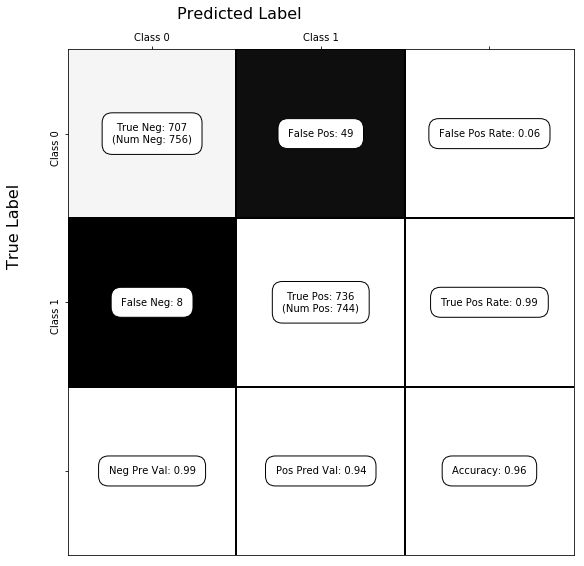

In [20]:
show_confusion_matrix(R, ['Class 0', 'Class 1'])

In [21]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
print(classification_report(y_valid,pred_rf, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       756
           1       0.94      0.99      0.96       744

   micro avg       0.96      0.96      0.96      1500
   macro avg       0.96      0.96      0.96      1500
weighted avg       0.96      0.96      0.96      1500



In [22]:
#rf.predict_proba(X_valid)[0:10,:]

In [23]:
pred_proba = rf.predict_proba(X_valid)[:,:]
y_pred_proba = pred_proba[:,1]

Text(0, 0.5, 'Frequency')

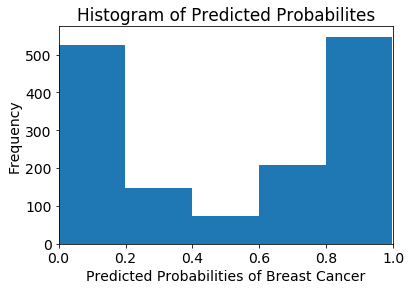

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size']=14
#Histogram of predicxted probaolities
plt.hist(y_pred_proba,bins = 5)
plt.xlim(0,1)
plt.title('Histogram of Predicted Probabilites')
plt.xlabel('Predicted Probabilities of Breast Cancer')
plt.ylabel('Frequency')

# ROC Curve and Area Under the Curve(AUC)

In [25]:
# print('y_train class distribution')
# print(y_train.value_counts(normalize=True))

In [26]:
fpr,tpr,thresholds = metrics.roc_curve(y_valid,y_pred_proba)
roc_auc = metrics.auc(fpr,tpr)
def  plot_roc_cur(fpr,tpr,label=None):
    plt.figure(figsize=(15,15))
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'g--')
    plt.xlim([0,1.0])
    plt.xlim([0,1.0])
    plt.axis([-0.005,1,0,1.005])
    plt.xticks(np.arange(0,1,0.05),rotation=90)
    plt.title('ROC for Breast Cancer Classifier')
    plt.xlabel('False Positive Rate(1-Specificity)')
    plt.ylabel('True Postive Rate')
    plt.legend(loc='best')
    plt.grid(True)

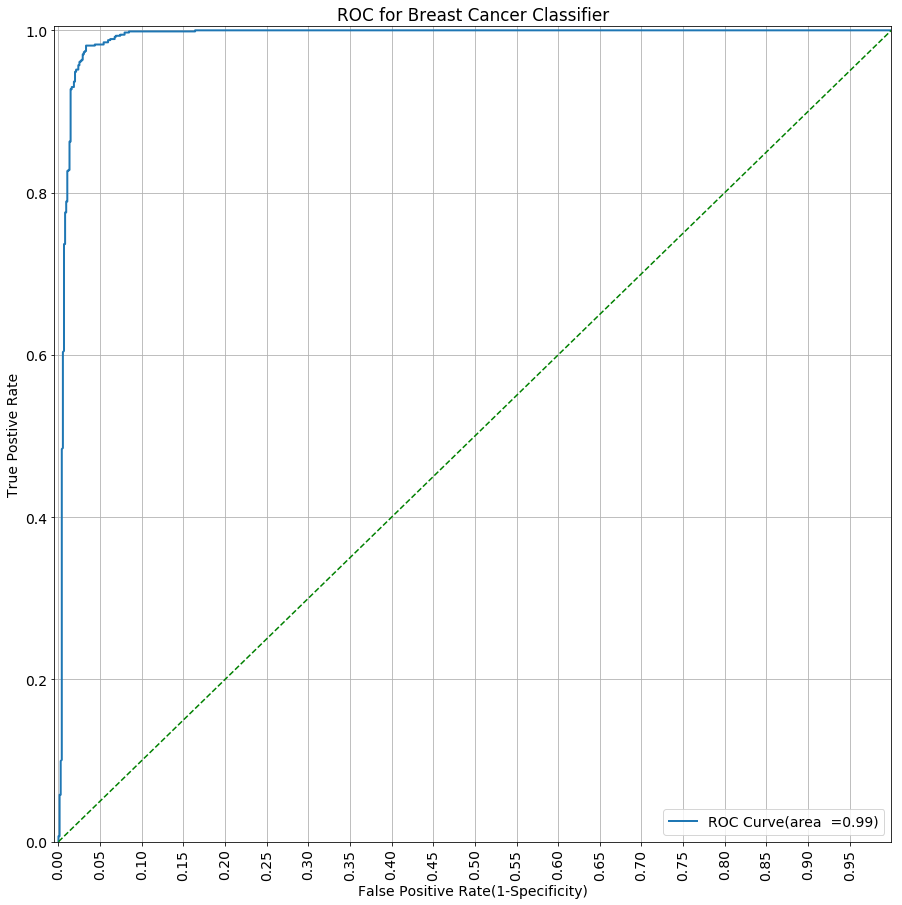

In [27]:
 plot_roc_cur(fpr,tpr,'ROC Curve(area  =%0.2f)'%roc_auc)

In [28]:
def evaluate_threshold(threshold):
    print('Sensitivity',tpr[thresholds>threshold][-1])
    print('Specificity',1-fpr[thresholds>threshold][-1])

In [29]:
from sklearn.preprocessing import binarize
pred_cl = binarize(pred_proba, 0.45)
pred_class = pred_cl[:,1]
R1 = metrics.confusion_matrix(y_valid,pred_class)

In [30]:
R1

array([[692,  64],
       [  2, 742]], dtype=int64)

In [31]:
#evaluate_threshold(0.55)

# Predicting the test data

In [32]:
test_pred_proba = rf.predict_proba(X_test)[:,:]
test_pred_cl = binarize(test_pred_proba, 0.35)
test_y_pred_proba = test_pred_cl[:,1]
#pred_proba

In [33]:
R2 = metrics.confusion_matrix(y_test,test_y_pred_proba)

In [34]:
R2

array([[490,  10],
       [  0, 500]], dtype=int64)